In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import optimize
from scipy.optimize import curve_fit

In [2]:
# import files
tube = readsav('../dat/f4.sav',verbose=True,python_dict=False) # tarr array
log10T,log10G = np.loadtxt('../dat/goft_1403.dat.txt',comments='%',unpack=True) # GofT data - Chianti

#create interpolatino function, GofT
te = 10**log10T
inter = interp1d(te,log10G,kind='cubic', bounds_error=False, fill_value=-10e6) #fill outide vals with large, small number

# set inital values
line = 1403.
mass = 28.0*1.66054e-27
kb = 1.3807e-23
c = 300
h = 6.62607e-27
flux=1.0e3 #? why this val?
ll = np.arange(line-10,line+10,0.01) # wavelengths
n = tube.tarr.n[0] # length of tarr.arrays

#init fittings params
amp1 = 1.2e14
sigma1 = 4
cen1 = 1404
amp2 = 0.8e14
sigma2 = 0.5
cen2 = 1403.5

--------------------------------------------------
Date: Tue Mar 24 14:00:36 2020
User: awill
Host: clark
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5
--------------------------------------------------
Successfully read 4 records of which:
 - 1 are of type VERSION
 - 1 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - tarr [<class 'numpy.recarray'>]
--------------------------------------------------


In [3]:
def mk_emission(time):
    # process to create volume given per flux (per Maxwell)
    rad=np.sqrt(flux/tube.tarr.b[time]/np.pi)
    b_e=0.5*( np.roll(tube.tarr.b[time], -1) + tube.tarr.b[time] )
    A1=rad
    A2=np.roll(rad,-1)
    #A2[tube.n-1]=A2[tube.n-2]
    A2[n-1]=A2[n-2]
    volume=(1./3.)*tube.tarr.dl_e[time]*(A1+A2+np.sqrt(A1*A2))*1e24
    #calcualte emission measure EM
    EM=volume*n_e**2
    return EM

def oneGauss(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

def twoGauss(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

In [4]:
t_n = tube.tarr.shape[0] - 1

center = np.zeros(t_n)
center1 = np.zeros(t_n)
center2 = np.zeros(t_n)

los_x = tube.tarr.x[0].T[0]
xpos =np.arange(0,np.ceil(los_x[-1]),0.25)
intensities = np.empty([t_n,len(ll)]) # create intensity arrary at each time step. 
ilam = np.empty([t_n,len(ll),len(xpos)])

for time in range(0,t_n):
    los_v = tube.tarr.v[time].T[0]
    sm_v = savgol_filter(los_v,3,1) # smooth velocity array
    los_x = tube.tarr.x[time].T[0]
    n_e = tube.tarr.epamu[time]*tube.tarr.rho[time]/1.67e-8 # number density
    
    
    sig = line*np.sqrt(kb*1e6*tube.tarr.t[time]/mass)/(c*1e6) # other thermal width
    #fwhm = line*np.sqrt(8*kb*tube.tarr.t[time]*np.log(2)/mass/c/c) # thermal width

    em=mk_emission(time)

    # interpolate our GofT data
    temp = 1e6*tube.tarr.t[time]
    G = inter(temp)
    G[temp<22000] = -10000 # set all log10G with low temp to large, small number (st 10^G~0)

    # interate over entire tube at given time
    emiss = np.empty([n,len(ll)])
    emiss2 = emiss
    for i in range(n):
        emiss[i,:] = em[i]*10**G[i]/np.sqrt(2*np.pi*sig[i])*np.exp(-(ll-line-line*sm_v[i]/c)**2/(2*sig[i]**2))
        emiss2[i,:] = em[i]*10**G[i]*line/(c*1e6)*np.exp(-(ll-line-line*sm_v[i]/c)**2/(2*sig[i]**2))

    # # emission possition information
    # xpos =np.arange(0,np.ceil(los_x[-1]),0.25)
    xhist = np.empty(n)
    #ilam = np.empty([len(ll),len(xpos)])
    ends = len(xpos)-1
    for j in range(ends):
        jj = np.where((los_x>xpos[j]) & (los_x<xpos[j+1]))
        ilam[time,:,j] = np.sum(emiss2[jj[0],:],axis=0)
    
            
    half=np.int(n/2)
    emiss = emiss[half:,:]
    emiss2 = emiss2[half:,:]
    tot_emiss = np.sum(emiss2,axis=0) # our emission data
    
    intensities[time,:] = tot_emiss

    # fitting
    popt_gauss, pcov_gauss = curve_fit(oneGauss, ll, tot_emiss, p0=[amp1, cen1, sigma1])
    #perr_gauss = np.sqrt(np.diag(pcov_gauss))
    center[time] = popt_gauss[1]
    
    #popt_2gauss, pcov_2gauss = curve_fit(twoGauss, ll, tot_emiss, \
                                                    #p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])
    
    #pars_1 = popt_2gauss[0:3]
    #pars_2 = popt_2gauss[3:6]
    #center1[time] = pars_1[1]
    #center2[time] = pars_2[1]

Text(0.5, 0, 'wavelength [$\\AA$]')

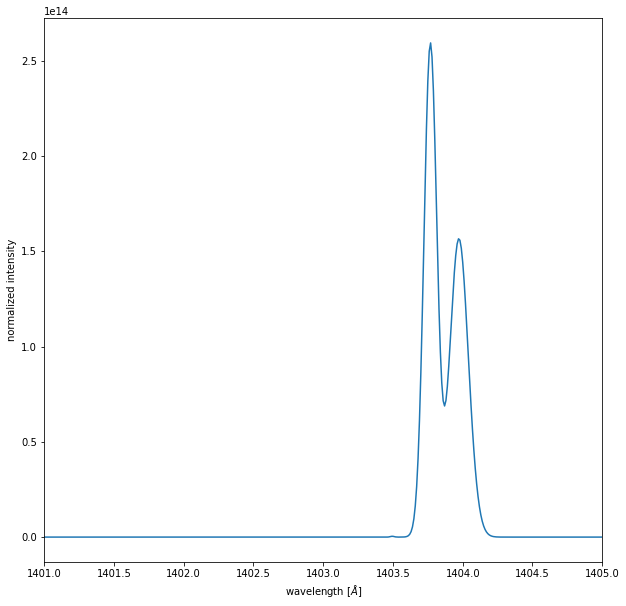

In [5]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,intensities[55,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

In [6]:
#delta_lambda = center2 - line
v0 = (center-line)/ line * 2.997E5 # in km/s
#v1 = (center1-line)/ line * 2.997E5
#v2 = (center2-line)/ line * 2.997E5
ti = np.arange(0,t_n)*0.1

(0, 230)

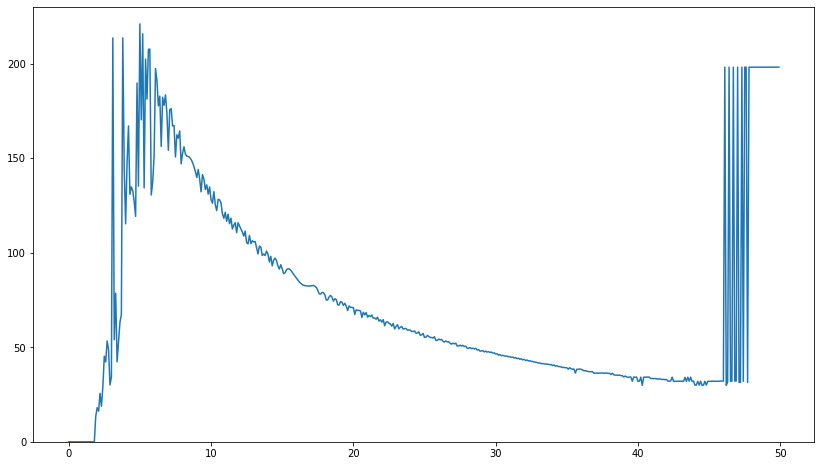

In [7]:
fig=plt.figure(figsize=[14,8])
#plt.plot(ti,v1,ti,v2)
#plt.plot(ti,v0,ti,v1)
plt.plot(ti,v0)
plt.ylim(0,230)

In [8]:
ilam=np.log(ilam)
ilam[ilam==-np.inf]=0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(1402, 1405)

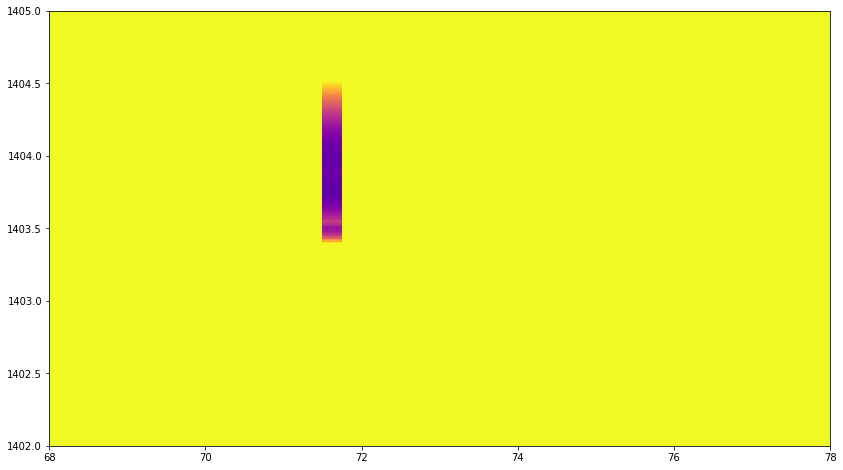

In [9]:
fig=plt.figure(figsize=[14,8])
plt.pcolormesh(xpos,ll,ilam[55],cmap = 'plasma_r',vmin=0,vmax=40)
plt.xlim(68,78)
plt.ylim(1402,1405)

Try to animate..

In [10]:
from matplotlib import animation, rc
from IPython.display import HTML

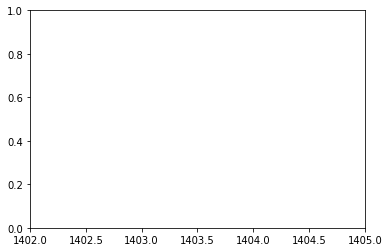

In [11]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 1402, 1405))
ax.set_ylim((0, 1))

line, = ax.plot([], [], lw=2)

In [15]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = ll
    y = intensities[i,:]/max(intensities[i,:])
    line.set_data(x, y)
    return (line,)

In [22]:
# call the animator. blit=True means only re-draw the parts that have changed.
#anim = animation.FuncAnimation(fig, animate, init_func=init,
                               #frames=100, interval=20, blit=True)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=10, blit=True)

In [23]:
HTML(anim.to_html5_video())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [24]:
#anim.save('try_animation.mp4', fps=10, dpi=80)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [26]:
HTML("""
    <video alt="test" controls>
        <source src="animation.mp4" type="video/mp4" width="420" height="315">
    </video>
""")